In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 999)

In [2]:
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor

In [3]:
df = pd.read_csv('Fire_Dep_Call_50%.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
cols = ['Available DtTm', 'Response DtTm', 'Dispatch DtTm', 'Received DtTm']
for col in cols:
    df[col] = pd.to_datetime(df[col], format='%m/%d/%Y %I:%M:%S %p', infer_datetime_format=True)

df['Respond to Available'] = df['Available DtTm'] - df['Response DtTm']
df['Call to Dispatch'] = df['Dispatch DtTm'] - df['Received DtTm']


In [7]:
time_cols = ['Respond to Available', 'Call to Dispatch']
df[time_cols] = df[time_cols].applymap(lambda t: t.total_seconds()/60)
df[time_cols] = df[time_cols].applymap(lambda x: max(x,0))

In [9]:
df['Month'] = df['Received DtTm'].dt.month
df['WeekDay'] = df['Received DtTm'].dt.weekday
df['Weekofyear'] = df['Received DtTm'].dt.weekofyear
df['Hours'] = df['Received DtTm'].dt.hour
df['Minutes'] = df['Received DtTm'].dt.minute

#---------added----------columns for hospital or transport
df['Hospital or Transport'] = (~(df['Transport DtTm'].isna() & df['Hospital DtTm'].isna())).astype('int')

In [11]:
def fill_na(df):
    q = df['Original Priority'].value_counts(normalize=True) #counts share of valeus in col w/o N/A
    orig_prio_list = q.index.tolist()  #makes indeces(priorities types) to a list
    orig_prio_shares = q.tolist() #makes values of shares a list
    df['Original Priority'] = df['Original Priority'].fillna(pd.Series(np.random.choice(orig_prio_list, p=orig_prio_shares, size=len(df))))

    w = df['Call Type Group'].value_counts(normalize=True) #counts share of values in col w/o N/A
    call_types_list = w.index.tolist()  #makes indeces(priorities types) to a list
    call_types_shares = w.tolist() #makes values of shares a list
    df['Call Type Group'] = df['Call Type Group'].fillna(pd.Series(np.random.choice(call_types_list, p=call_types_shares, size=len(df))))
    
fill_na(df)

if((df['Zipcode of Incident'].nunique()) <= (df['Neighborhooods - Analysis Boundaries'].nunique())):
    zipcodes = df[['Neighborhooods - Analysis Boundaries','Zipcode of Incident']]
    zipcodes = zipcodes[zipcodes['Zipcode of Incident'].notnull()]
    zips= list(zipcodes['Zipcode of Incident'].values)
    nbhds= list(zipcodes['Neighborhooods - Analysis Boundaries'].values)
    if len(zips) == len(nbhds):
        zipcodes_dict=dict(zip(nbhds,zips))

    else: 
        print('Count unique zipcodes != count neighborhooods, something went wrong.')
else:
    print('More zipcodes than neighborhooods, we need new strategy!')

df['Zipcode of Incident'] = df['Zipcode of Incident'].fillna(df['Neighborhooods - Analysis Boundaries'].map(zipcodes_dict))
df['Zipcode of Incident'] = df['Zipcode of Incident'].astype(int)

In [13]:
df['Location'] = df['Location'].astype(tuple)
locations = df['Location'].str[1:-1].str.split(',', expand=True).astype(float)
df[locations.columns]= locations

In [17]:
#only not null, not zero and less that 10 hours to solve
df = df[(df['Respond to Available'].notnull()) & (df['Respond to Available'] <= 360) & (df['Respond to Available']>0.25)]

In [18]:
#------cancelled dropping of 'Call to Dispatch','Minutes','Month', 'WeekDay', 'Call Type', 
df1 = df.drop(columns=['Call Number', 'Incident Number', 'Call Type Group', 'Call Date', 'Watch Date', 
                      'Received DtTm', 'Entry DtTm', 'Dispatch DtTm','Response DtTm', 'On Scene DtTm',
                      'Transport DtTm','Hospital DtTm', 'Call Final Disposition', 'Available DtTm',
                      'Supervisor District', 'Original Priority',
                      'Address', 'City', 'Priority', 'Final Priority',  'Location', 'Month', 'WeekDay',  
                      'RowID', 'Battalion', 'ALS Unit'], errors='ignore')

In [19]:
df1 = df1.dropna(how='any') 

In [20]:
df1.shape

(2038389, 18)

In [21]:
y = df1['Respond to Available']
X = df1.drop(columns=['Respond to Available'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1426872 entries, 1 to 1648584
Data columns (total 17 columns):
Unit ID                                 1426872 non-null object
Call Type                               1426872 non-null object
Zipcode of Incident                     1426872 non-null int64
Station Area                            1426872 non-null object
Box                                     1426872 non-null float64
Number of Alarms                        1426872 non-null int64
Unit Type                               1426872 non-null object
Unit sequence in call dispatch          1426872 non-null int64
Fire Prevention District                1426872 non-null object
Neighborhooods - Analysis Boundaries    1426872 non-null object
Call to Dispatch                        1426872 non-null float64
Weekofyear                              1426872 non-null int64
Hours                                   1426872 non-null int64
Minutes                                 1426872 non-null i

In [23]:
cat_features=[
    0,
    1,
    3,
    6,
    8,
    9
]

In [24]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features)

In [25]:
model = CatBoostRegressor(iterations=200, depth=10,learning_rate=0.1)
model.fit(train_pool)

0:	learn: 33.1190751	total: 3.62s	remaining: 12m
1:	learn: 30.7790504	total: 6.77s	remaining: 11m 10s
2:	learn: 28.7380710	total: 10.2s	remaining: 11m 8s
3:	learn: 26.9690839	total: 13.1s	remaining: 10m 40s
4:	learn: 25.4451154	total: 15.5s	remaining: 10m 5s
5:	learn: 24.1267572	total: 18.1s	remaining: 9m 44s
6:	learn: 23.0020776	total: 20.9s	remaining: 9m 34s
7:	learn: 22.0461638	total: 23.2s	remaining: 9m 17s
8:	learn: 21.2282577	total: 25.7s	remaining: 9m 4s
9:	learn: 20.5382089	total: 28.4s	remaining: 9m
10:	learn: 19.9632218	total: 31.3s	remaining: 8m 58s
11:	learn: 19.4661859	total: 33.7s	remaining: 8m 48s
12:	learn: 19.0518342	total: 36.5s	remaining: 8m 44s
13:	learn: 18.7057780	total: 38.7s	remaining: 8m 34s
14:	learn: 18.4257680	total: 41.3s	remaining: 8m 29s
15:	learn: 18.1861958	total: 44.6s	remaining: 8m 32s
16:	learn: 17.9873484	total: 47.8s	remaining: 8m 34s
17:	learn: 17.8138483	total: 50.9s	remaining: 8m 34s
18:	learn: 17.6541259	total: 53.6s	remaining: 8m 30s
19:	learn

152:	learn: 16.2284682	total: 7m 50s	remaining: 2m 25s
153:	learn: 16.2251880	total: 7m 53s	remaining: 2m 22s
154:	learn: 16.2209813	total: 7m 56s	remaining: 2m 19s
155:	learn: 16.2178059	total: 7m 59s	remaining: 2m 16s
156:	learn: 16.2146933	total: 8m 3s	remaining: 2m 13s
157:	learn: 16.2123556	total: 8m 6s	remaining: 2m 10s
158:	learn: 16.2100156	total: 8m 9s	remaining: 2m 6s
159:	learn: 16.2052409	total: 8m 12s	remaining: 2m 3s
160:	learn: 16.2035928	total: 8m 15s	remaining: 2m
161:	learn: 16.2007892	total: 8m 17s	remaining: 1m 57s
162:	learn: 16.1987674	total: 8m 20s	remaining: 1m 54s
163:	learn: 16.1961654	total: 8m 24s	remaining: 1m 51s
164:	learn: 16.1949071	total: 8m 26s	remaining: 1m 48s
165:	learn: 16.1921894	total: 8m 30s	remaining: 1m 45s
166:	learn: 16.1908249	total: 8m 33s	remaining: 1m 42s
167:	learn: 16.1887927	total: 8m 36s	remaining: 1m 38s
168:	learn: 16.1875148	total: 8m 39s	remaining: 1m 35s
169:	learn: 16.1856625	total: 8m 43s	remaining: 1m 32s
170:	learn: 16.1837

In [26]:
model.score(test_pool, y_test)  #

15.919319026189518

In [27]:
pred = model.predict(test_pool)

In [28]:
XYY = X_test.copy()
XYY['y_test'] = y_test
XYY['y_pred'] = pred
XYY['y_test-y_pred'] = XYY['y_test']-XYY['y_pred']
XYY['y_test-y_pred_squared'] = XYY['y_test-y_pred']**2
mean_y = XYY['y_pred'].mean()
XYY['mean_y'] = mean_y
XYY['diff'] = XYY['y_test']-XYY['mean_y']
XYY.head(5)

,Unit ID,Call Type,Zipcode of Incident,Station Area,Box,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Neighborhooods - Analysis Boundaries,Call to Dispatch,Weekofyear,Hours,Minutes,Hospital or Transport,0,1,y_test,y_pred,y_test-y_pred,y_test-y_pred_squared,mean_y,diff
1648585,MA1,Train / Rail Incident,94111,13,2809.0,1,SUPPORT,13,1,Financial District/South Beach,2.083333,23,9,7,0,37.792824,-122.397034,38.966667,74.780001,-35.813334,1282.594884,26.094591,12.872075
1648586,RC2,Train / Rail Incident,94111,13,2809.0,1,RESCUE CAPTAIN,12,1,Financial District/South Beach,2.083333,23,9,7,0,37.792824,-122.397034,66.266667,54.418434,11.848233,140.380625,26.094591,40.172075
1648587,RS1,Train / Rail Incident,94111,13,2809.0,1,RESCUE SQUAD,1,1,Financial District/South Beach,2.083333,23,9,7,0,37.792824,-122.397034,47.166667,51.706421,-4.539754,20.609365,26.094591,21.072075
1648588,T08,Train / Rail Incident,94111,13,2809.0,1,TRUCK,8,1,Financial District/South Beach,2.083333,23,9,7,0,37.792824,-122.397034,62.266667,60.436844,1.829823,3.348253,26.094591,36.172075
1648589,T13,Train / Rail Incident,94111,13,2809.0,1,TRUCK,4,1,Financial District/South Beach,2.083333,23,9,7,0,37.792824,-122.397034,54.700000,51.415826,3.284174,10.785800,26.094591,28.605409


In [29]:
mae = (abs(XYY['y_test-y_pred']).sum())/len(XYY['y_test-y_pred'])
mse = (XYY['y_test-y_pred']**2).sum()/len(XYY['y_test-y_pred'])
rmse = mse**0.5
determanation_score = 1-((XYY['y_test-y_pred']**2).sum())/((XYY['diff']**2).sum())

In [30]:
mae

9.790150183645451

In [31]:
mse

253.42471825759958

In [32]:
rmse

15.919319026189518

In [33]:
determanation_score

0.670844903021047

In [25]:
#scores compare to mean
total_mean = y_train.mean()
mae_mean = (abs(XYY['y_test']-total_mean).sum())/len(XYY['y_test-y_pred'])
print('mae_mean: '+ str(mae_mean))
mse_mean = ((XYY['y_test']-total_mean)**2).sum()/len(XYY['y_test-y_pred'])
print('mse_mean: '+ str(mse_mean))
rmse_mean = mse_mean**0.5
print('mrse_mean: '+ str(rmse_mean))

mae_mean: 1321.861401961035
mse_mean: 2787813.019818711
mrse_mean: 1669.6745251152126


In [26]:
val = model.get_feature_importance()
feat = X_test.columns

list(zip(feat,val))

[('Unit ID', 3.5261619709332623),
 ('Call Type', 4.846185573847623),
 ('Zipcode of Incident', 1.7027669113551278),
 ('Station Area', 1.3459119047897528),
 ('Box', 2.8370940277866565),
 ('Number of Alarms', 14.061306561784868),
 ('Unit Type', 10.852290158303887),
 ('Unit sequence in call dispatch', 6.814616897523427),
 ('Fire Prevention District', 1.5079524017537211),
 ('Neighborhooods - Analysis Boundaries', 1.4758541918679036),
 ('Call to Dispatch', 3.4364287588214983),
 ('Weekofyear', 1.1681765828665176),
 ('Hours', 3.6451127079461307),
 ('Minutes', 1.133360747710849),
 ('Hospital or Transport', 36.29725153999676),
 (0, 2.80335721626495),
 (1, 2.546171846447061)]

[('Battalion', 0.5078027445356504),
 ('Station Area', 6.135001357254266),
 ('Box', 9.114046028348575),
 ('Original Priority', 1.9631004892661137),
 ('ALS Unit', 0.8674294353822795),
 ('Call Type Group', 3.333459641176911),
 ('Unit Type', 41.73743300645736),
 ('Fire Prevention District', 1.5738692854230882),
 ('Supervisor District', 1.5693252610655513),
 ('Month', 0.5003596981995669),
 ('WeekDay', 0.7519625648056559),
 ('Weekofyear', 1.623724419771495),
 ('Hours', 8.179958110857296),
 ('Minutes', 1.0530441606569498),
 ('Call Type Merged', 21.08948379679924)]
 
 [('Station Area', 6.994516107181966),
 ('Box', 5.876354709490432),
 ('Original Priority', 0.9627007503785607),
 ('Call Type Group', 1.29599635276719),
 ('Unit Type', 60.51084666020504),
 ('Fire Prevention District', 0.3122714646717646),
 ('Supervisor District', 0.5588749902917611),
 ('Weekofyear', 0.0),
 ('Hours', 3.0604472528149556),
 ('Minutes', 0.0),
 ('Call Type Merged', 20.427991712198327)]

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

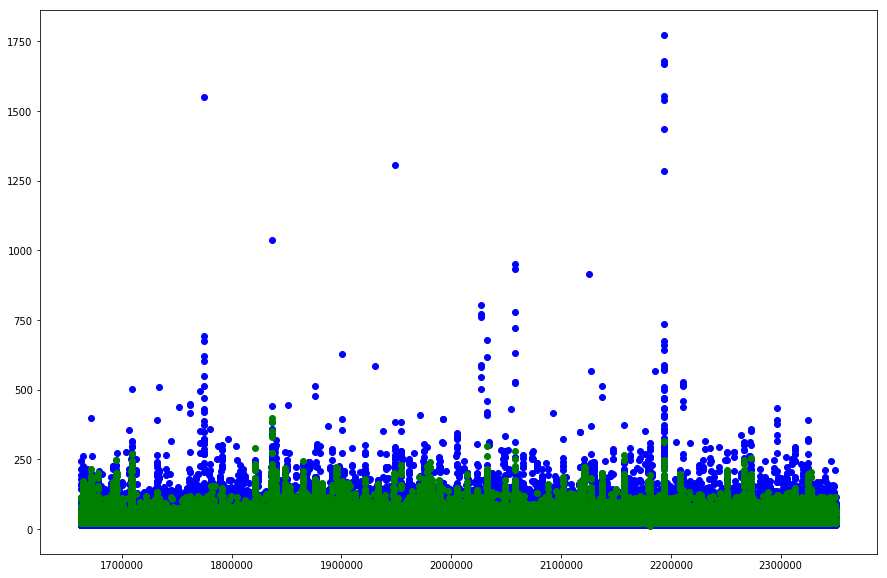

In [28]:
XYY = XYY.sort_values('y_test')
plt.figure(figsize=(15,10))
plt.scatter(XYY.index, XYY['y_test'].sort_values(), color='b')
plt.scatter(XYY.index, XYY['y_pred'], color='g')
plt.show()

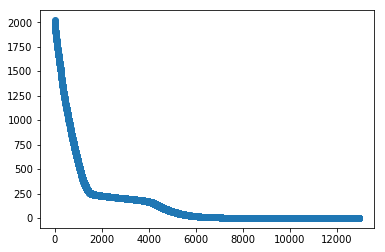

In [47]:
plt.scatter(range(0,12957), df1['Respond to Available'].value_counts())

In [82]:
df1[df1['Respond to Available']> 25n000].count()  #2046293

Unit ID                                 191
Call Type                               191
Zipcode of Incident                     191
Station Area                            191
Box                                     191
Number of Alarms                        191
Unit Type                               191
Unit sequence in call dispatch          191
Fire Prevention District                191
Neighborhooods - Analysis Boundaries    191
Respond to Available                    191
Call to Dispatch                        191
Weekofyear                              191
Hours                                   191
Minutes                                 191
Hospital or Transport                   191
0                                       191
1                                       191
dtype: int64

###### df1[df['Respond to Available']==0]

389